<a href="https://colab.research.google.com/github/mohsenfayyaz/edge-probe/blob/main/Edge_Probing_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations & Imports

In [ ]:
! nproc
! lscpu
! nvidia-smi

2
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibr

In [ ]:
! git clone https://github.com/mohsenfayyaz/edge-probing-datasets.git
! pip install datasets
! pip install transformers
! pip install wandb

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display
import torch
import numpy as np
import shutil
import os
import datasets
import json
import gc
import datetime
import torch.nn as nn
from abc import ABC, abstractmethod
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import f1_score
import psutil  # RAM usage
# import wandb
# wandb.init()
print(torch.__version__)

1.8.1+cu101


# Configs

In [ ]:
class Dataset_info:
    def __init__(self, dataset_name, num_of_spans, max_span_length=5):
        self.dataset_name = dataset_name
        self.num_of_spans = num_of_spans

In [ ]:
# model_checkpoint = 'xlnet-base-cased'
# model_checkpoint = "xlnet-large-cased"
model_checkpoint = "distilbert-base-cased"
# model_checkpoint = "bert-base-cased"
# model_checkpoint = "bert-large-cased"
# model_checkpoint = "albert-xxlarge-v2"
# model_checkpoint = "t5-small"
# model_checkpoint ="t5-large"
# model_checkpoint = "mohsenfayyaz/toxicity-classifier"


my_dataset_info = Dataset_info("dpr", num_of_spans=2)
# my_dataset_info = Dataset_info("ud", num_of_spans=2)

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MAX_RAM_USAGE = 90
MAX_CACHE_LEN = 3000
CACHE = True

# Prepare Dataset & Spans

In [ ]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  
model = AutoModel.from_pretrained(model_checkpoint)

In [ ]:
model.save_pretrained(model_checkpoint)
tokenizer.save_pretrained(model_checkpoint)

('distilbert-base-cased/tokenizer_config.json',
 'distilbert-base-cased/special_tokens_map.json',
 'distilbert-base-cased/vocab.txt',
 'distilbert-base-cased/added_tokens.json')

In [ ]:
class Utils:
    def one_hot(idx, length):
        import numpy as np
        o = np.zeros(length, dtype=np.int8)
        o[idx] = 1
        return o

In [ ]:
class Dataset_handler:
    def __init__(self, dataset_info: Dataset_info):
        self.dataset = datasets.DatasetDict()
        self.tokenized_dataset = None
        self.dataset_info = dataset_info
        self.labels_list = None

        if dataset_info.dataset_name == "dpr":
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/train.json', data_type="train")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/dev.json', data_type="dev")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/test.json', data_type="test")
        elif dataset_info.dataset_name == "ud":
            frac = 1
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-train.json', data_type="train", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-dev.json', data_type="dev", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-test.json', data_type="test", fraction = frac)
        else:
            throw("Error: Unkown dataset name!")

        print("⌛ Tokenizing Dataset and Adding One Hot Representation of Labels")
        self.tokenized_dataset = self.tokenize_input_and_one_hot_labels(self.dataset)
        # self.tokenized_dataset = self.tokenize_dataset(self.dataset)
        # print("⌛ Adding One Hot Representation of Labels")
        # self.tokenized_dataset = self.one_hot_dataset_labels(self.tokenized_dataset)
        

    # Public:
    def json_to_dataset(self, json_path, data_type="train", fraction=1):
        data_df = self.json_to_df(json_path)
        # print(data_type, "text max length:", data_df["text"].str.len().max())  # max length of texts
        if fraction != 1:
            data_df = data_df.sample(frac=fraction, random_state=1).sort_index().reset_index(drop=True)
        self.dataset[data_type] = datasets.Dataset.from_pandas(data_df)
        return self.dataset
    
    def tokenize_input_and_one_hot_labels(self, dataset):
        train_df = pd.DataFrame(dataset["train"]["label"], columns=['label'])
        dev_df = pd.DataFrame(dataset["dev"]["label"], columns=['label'])
        test_df = pd.DataFrame(dataset["test"]["label"], columns=['label'])
        self.labels_list = list(set(train_df["label"].unique()).union
                               (set(dev_df["label"].unique())).union
                               (set(test_df["label"].unique())))
        self.label_to_index = dict()
        for idx, l in enumerate(self.labels_list):
            self.label_to_index[l] = idx
        tokenized_one_hot_dataset = dataset.map(tokenize_and_one_hot,
                                                fn_kwargs={"label_to_index": self.label_to_index,
                                                           "labels_len": len(self.label_to_index),
                                                           "tokenizer": tokenizer,
                                                           "one_hot_func": Utils.one_hot
                                                           },
                                                batched=False,
                                                num_proc=None)
        return tokenized_one_hot_dataset

    # Private:
    def json_to_df(self, json_path):
        with open(json_path, encoding='utf-8') as file:
            data_list = list()
            for line in file:
                instance = json.loads(line)
                for target in instance["targets"]:
                    data_list.append({"text": instance["text"], 
                                    "span1": target["span1"],
                                    "span2": target["span2"],
                                    "label": target["label"]})
        return pd.DataFrame.from_dict(data_list)

def tokenize_and_one_hot(examples, **fn_kwargs):
    # tokenize and align spans
    thread_tokenizer = fn_kwargs["tokenizer"]
    one_hot_func = fn_kwargs["one_hot_func"]
    tokenized_inputs = thread_tokenizer(examples["text"])
    # tokenized_inputs = tokenizer(examples["text"], truncation=True, is_split_into_words=True, padding="max_length", max_length=210)
    word_ids = tokenized_inputs.word_ids()
    tokenized_inputs["span1"] = [0, 0]
    tokenized_inputs["span2"] = [0, 0]
    tokenized_inputs["span1"][0] = word_ids.index(examples["span1"][0])  # First occurance
    tokenized_inputs["span1"][1] = len(word_ids) - 1 - word_ids[::-1].index(
        examples["span1"][1] - 1) + 1  # Last occurance (+1 for open range)
    tokenized_inputs["span2"][0] = word_ids.index(examples["span2"][0])  # First occurance
    tokenized_inputs["span2"][1] = len(word_ids) - 1 - word_ids[::-1].index(
        examples["span2"][1] - 1) + 1  # Last occurance
    tokenized_inputs["span1_len"] = tokenized_inputs["span1"][1] - tokenized_inputs["span1"][0]
    tokenized_inputs["span2_len"] = tokenized_inputs["span2"][1] - tokenized_inputs["span2"][0]
    # One hot
    label_to_index = fn_kwargs["label_to_index"]
    labels_len = fn_kwargs["labels_len"]
    tokenized_inputs["one_hot_label"] = one_hot_func(label_to_index[examples["label"]], labels_len)
    return tokenized_inputs

In [ ]:
my_dataset_handler = Dataset_handler(my_dataset_info);

⌛ Tokenizing Dataset and Adding One Hot Representation of Labels
  

,attention_mask,input_ids,label,one_hot_label,span1,span1_len,span2,span2_len,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",not-entailed,"[1, 0]","[8, 9]",1,"[1, 3]",2,The bee landed on the flower because it had po...
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",entailed,"[0, 1]","[8, 9]",1,"[5, 7]",2,The bee landed on the flower because it had po...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[101, 1109, 17775, 4860, 1113, 1103, 7366, 127...",entailed,"[0, 1]","[8, 9]",1,"[1, 3]",2,The bee landed on the flower because it wanted...


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text'],
        num_rows: 1787
    })
    dev: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text'],
        num_rows: 379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text'],
        num_rows: 949
    })
})
Original Spans: {'text': 'Lions eat zebras because they are predators .', 'span1': [4, 5], 'span2': [0, 1], 'label': 'entailed'}
Tokenized Spans: {'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'input_ids': [101, 7862, 3940, 195, 15581, 7297, 1272, 1152, 1132, 15334, 119, 102], 'label': 'entailed', 'one_hot_label': [0, 1], 'span1': [7, 8], 'span1_len': 1, 'span2': [1, 2], 'span2_len': 1, 'text': 'Lions eat zebras because they are preda

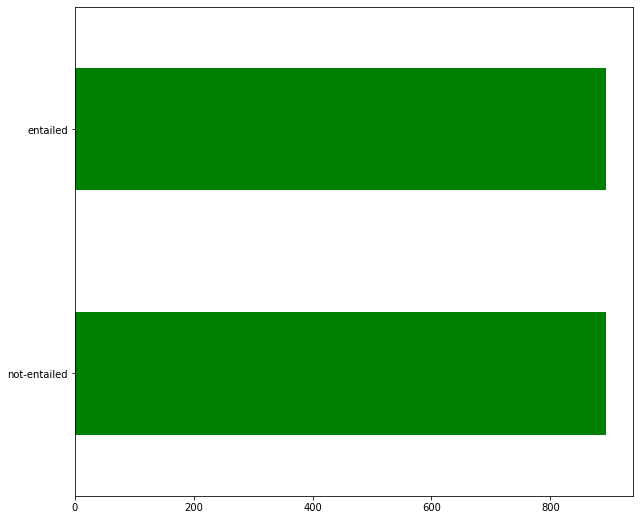

In [ ]:
# Check
rnd_idx = np.random.randint(100)
part = "train"

display(pd.DataFrame(my_dataset_handler.tokenized_dataset[part][0:3]))
print(my_dataset_handler.tokenized_dataset)
print("Original Spans:", my_dataset_handler.dataset[part][rnd_idx])
print("Tokenized Spans:", my_dataset_handler.tokenized_dataset[part][rnd_idx])
test_tokens = tokenizer.convert_ids_to_tokens(my_dataset_handler.tokenized_dataset[part][rnd_idx]["input_ids"])
print(test_tokens)

s10, s11 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][-1]
s20, s21 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][-1]
print("span1:", s10, s11, test_tokens[s10:s11])
print("span2:", s20, s21, test_tokens[s20:s21])
print("label:", my_dataset_handler.tokenized_dataset[part][rnd_idx]["label"])

pd.DataFrame(my_dataset_handler.tokenized_dataset[part]["label"], columns=['label'])["label"].value_counts().plot(kind='barh', color="green", figsize=(10, 9));

# Edge Probe

In [ ]:
class SpanRepr(ABC, nn.Module):
    """Abstract class describing span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256):
        super(SpanRepr, self).__init__()
        self.input_dim = input_dim
        self.proj_dim = proj_dim
        self.use_proj = use_proj

    @abstractmethod
    def forward(self, spans, attention_mask):
        raise NotImplementedError

    def get_input_dim(self):
        return self.input_dim

    @abstractmethod
    def get_output_dim(self):
        raise NotImplementedError

class MaxSpanRepr(SpanRepr, nn.Module):
    """Class implementing the max-pool span representation."""

    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        return:
            [32, 13, 256]
        """
        # TODO: Vectorize this
        for i in range(len(attention_mask)):
            for j in range(len(attention_mask[i])):
                if attention_mask[i][j] == 0:
                    spans[i, :, j, :] = -1e10

        # print(spans[0])
        max_span_repr, max_idxs = torch.max(spans, dim=-2)
        # print(max_span_repr.shape)
        return max_span_repr

    def get_output_dim(self):
        if self.use_proj:
            return self.proj_dim
        else:
            return self.input_dim

def get_span_module(input_dim, method="max", use_proj=False, proj_dim=256):
    """Initializes the appropriate span representation class and returns the object.
    """
    if method == "avg":
        return AvgSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "max":
        return MaxSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff":
        return DiffSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff_sum":
        return DiffSumSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "endpoint":
        return EndPointRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent":
        return CoherentSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent_original":
        return CoherentOrigSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "attn":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coref":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim, use_endpoints=True)
    else:
        raise NotImplementedError

In [ ]:
class Edge_probe_model(nn.Module):
    def __init__(self, num_layers, input_span_len, embedding_dim, num_classes, pool_method='max', use_proj=True, proj_dim=256, hidden_dim=256, device='cuda'):
        super(Edge_probe_model, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.weighing_params = nn.Parameter(torch.ones(self.num_layers))
        self.input_dim = 2 * embedding_dim
        if use_proj:
            # Apply a projection layer to output of pretrained models
            print(embedding_dim, num_layers, proj_dim)
            self.proj1 = nn.Linear(embedding_dim, proj_dim)
            self.proj2 = nn.Linear(embedding_dim, proj_dim)
            # Update the input_dim
            self.input_dim = 2 * proj_dim
        else:
            self.proj1 = None

        self.span1_pooling_net = get_span_module(embedding_dim)
        self.span2_pooling_net = get_span_module(embedding_dim)

        self.label_net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.Tanh(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, self.num_classes),
            nn.Sigmoid()
        )
        self.training_criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4, weight_decay=0)

    def forward(self, spans_torch_dict):
        span1_reprs = spans_torch_dict["span1"]
        span2_reprs = spans_torch_dict["span2"]
        span1_attention_mask = spans_torch_dict["span1_attention_mask"]
        span2_attention_mask = spans_torch_dict["span2_attention_mask"]
        # print(span1_reprs.shape)
        if self.proj1:
            span1_reprs = self.proj1(span1_reprs)
            span2_reprs = self.proj2(span2_reprs)
        
        pooled_span1 = self.span1_pooling_net(span1_reprs, span1_attention_mask)
        pooled_span2 = self.span2_pooling_net(span2_reprs, span2_attention_mask)

        # print(my_dataset_handler.tokenized_dataset["train"][0])
        # print("SPAN1", span1_reprs[2, :, :, 0:5])
        # print("SPAN2", span2_reprs[2, :, :, 0:5])
        # print("MAX1", pooled_span1[2, :, 0:5])
        # print("MAX2", pooled_span2[2, :, 0:5])
        # raise "E"
        
        output = torch.cat((pooled_span1, pooled_span2), dim=-1)
        # print(output.shape)  # torch.Size([32, 13, 512])

        wtd_encoded_repr = 0
        soft_weight = nn.functional.softmax(self.weighing_params, dim=0)
        for i in range(self.num_layers):
            wtd_encoded_repr += soft_weight[i] * output[:, i, :]
        # wtd_encoded_repr += soft_weight[-1] * encoded_layers[:, -1, :]
        output = wtd_encoded_repr

        pred_label = self.label_net(output)
        pred_label = torch.squeeze(pred_label, dim=-1)
        return pred_label

    def summary(self):
        print(self)
        pytorch_total_params = sum(p.numel() for p in self.parameters())
        pytorch_total_params_trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("Total Parameters:    ", pytorch_total_params)
        print("Trainable Parameters:", pytorch_total_params_trainable)

In [108]:
class Edge_probe_trainer:
    # Public:
    def __init__(self, language_model, dataset_handler: Dataset_handler, verbose=True, device='cuda', edge_probe_model_checkpoint=None):
        self.dataset_handler = dataset_handler
        self.language_model = language_model
        self.language_model.config.output_hidden_states = True
        self.device = device
        self.verbose = verbose
        def vprint(text):
            if verbose:
                print(datetime.datetime.now().time(), text)
        self.vprint = vprint

        self.current_hidden_states = None
        self.last_input_ids = None
        self.cached_hidden_states = {"input_ids": [], "hidden_states": [], "len": 0}

        self.vprint("Moving to device")
        self.language_model.to(self.device)
        num_layers, input_span_len, embedding_dim, num_classes = self.get_language_model_properties()
        self.MLP_device = "cpu"
        if edge_probe_model_checkpoint == None:
            print("Creating New EPM")
            self.edge_probe_model = Edge_probe_model(
                num_layers = num_layers,
                input_span_len = input_span_len,
                embedding_dim = embedding_dim, 
                num_classes = num_classes,
                device = self.MLP_device
            )
        else:
            print("Starting From a Pretrained EPM")
            self.edge_probe_model = edge_probe_model_checkpoint

        self.history = {"loss": {"train": [], "dev": [], "test": []}, 
                        "metrics": 
                        {"micro_f1": {"dev": [], "test": []}}}
    
    def train(self, batch_size, epochs=3):
        tokenized_dataset = self.dataset_handler.tokenized_dataset["train"]
        tokenized_dataset_dev = self.dataset_handler.tokenized_dataset["dev"]
        tokenized_dataset_test = self.dataset_handler.tokenized_dataset["test"]

        # self.edge_probe_model.to(self.device)
        self.edge_probe_model.to(self.MLP_device)
        # self.vprint("Counting dataset rows")
        dataset_len = len(tokenized_dataset["input_ids"])
        dev_dataset_len = len(tokenized_dataset_dev)
        test_dataset_len = len(tokenized_dataset_test)
        print(f"Train on {dataset_len} samples, validate on {dev_dataset_len} samples, test on {test_dataset_len} samples")
        # dataset_len = 60
        self.update_history(epoch = 0)
        for epoch in range(epochs):
            running_loss = 0.0
            steps = 0
            self.draw_weights(epoch)
            print("----------------\n")
            for i in tqdm(range(0, dataset_len, batch_size), desc=f"[Epoch {epoch + 1}/{epochs}]", postfix={'train_loss': running_loss / steps if steps != 0 else 0}):
                # if int(i / batch_size) % 1000 == 0:
                #     print("memory:", psutil.virtual_memory().percent)
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                # print(f"WWW[{i}, {i+step})")
                
                # self.vprint("Extracting")
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # zero the parameter gradients
                self.edge_probe_model.optimizer.zero_grad()
    
                # forward + backward + optimize
                # self.vprint("Forward MLP")
                outputs = self.edge_probe_model(spans_torch_dict)
                # self.vprint("Loss")
                loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.edge_probe_model.parameters(), 5.0)
                self.edge_probe_model.optimizer.step()
                # self.vprint("Done")
    
                # print statistics
                running_loss += loss.item()
                steps += 1
                # print(f"loss: {running_loss / steps}")

            self.update_history(epoch + 1, train_loss = running_loss / steps)
            

    def calc_loss(self, tokenized_dataset, batch_size=16, print_metrics=False, just_micro=False, desc=""):
        with torch.no_grad():
            running_loss = 0
            dataset_len = len(tokenized_dataset["input_ids"])
            steps = 0
            preds = None
            for i in tqdm(range(0, dataset_len, batch_size), desc=desc):
                # if int(i / batch_size) % 100 == 0:
                #     print("memory:", psutil.virtual_memory().percent, gc.collect(), psutil.virtual_memory().percent)
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # forward
                outputs = self.edge_probe_model(spans_torch_dict)
                preds = outputs if i == 0 else torch.cat((preds, outputs), 0)
                loss = self.edge_probe_model.training_criterion(outputs.to('cpu'), labels.float().to('cpu'))
                running_loss += loss.item()
                steps += 1

        preds = preds.cpu().argmax(-1)
        y_true = np.array(tokenized_dataset["one_hot_label"]).argmax(-1)
        print(preds[0:9])
        print(y_true[0:9])
        micro_f1 = f1_score(preds, y_true, average='micro')
        
        if print_metrics:
            labels_list = self.dataset_handler.labels_list
            if not just_micro:
                print(classification_report(preds, y_true, target_names=labels_list, labels=range(len(labels_list))))
            print("MICRO F1:", micro_f1)
        return running_loss / steps, micro_f1

    # Private:
    def update_history(self, epoch, train_loss = None):
        if train_loss is None:
            train_loss, train_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["train"], print_metrics=True, desc="Train Loss")
        dev_loss, dev_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["dev"], print_metrics=True, desc="Dev Loss")
        test_loss, test_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["test"], print_metrics=True, desc="Test Loss")
        self.history["loss"]["train"].append(train_loss)
        self.history["loss"]["dev"].append(dev_loss)
        self.history["loss"]["test"].append(test_loss)
        self.history["metrics"]["micro_f1"]["dev"].append(dev_f1)
        self.history["metrics"]["micro_f1"]["test"].append(test_f1)
        print('[%d] loss: %.4f, val_loss: %.4f, test_loss: %.4f' % (epoch, self.history["loss"]["train"][-1], self.history["loss"]["dev"][-1], self.history["loss"]["test"][-1]))

    def draw_weights(self, epoch=0):
        if(epoch % 1 == 0):
            w = self.edge_probe_model.weighing_params.tolist()
            print(w)
            plt.bar(np.arange(len(w)), w)
            plt.ylabel('Weight')
            plt.xlabel('Layer');
            plt.show()

    def prepare_batch_data(self, tokenized_dataset, start_idx, end_idx, pad=False):
        # self.vprint("Extracting From Model")
        span_representations_dict = self.extract_embeddings(tokenized_dataset, start_idx, end_idx, pad=True)
        # self.vprint("To Device")
        span1_torch = torch.tensor(np.array(span_representations_dict["span1"])).float().to(self.MLP_device)  # (batch_size, #layers, max_span_len, embd_dim)
        span2_torch = torch.tensor(np.array(span_representations_dict["span2"])).float().to(self.MLP_device)
        span1_attention_mask_torch = torch.tensor(np.array(span_representations_dict["span1_attention_mask"]))
        span2_attention_mask_torch = torch.tensor(np.array(span_representations_dict["span1_attention_mask"]))
        one_hot_labels_torch = torch.tensor(np.array(span_representations_dict["one_hot_label"]))
        # self.vprint("Done")
        spans_torch_dict = {"span1": span1_torch, 
                            "span2": span2_torch, 
                            "span1_attention_mask": span1_attention_mask_torch, 
                            "span2_attention_mask": span2_attention_mask_torch, 
                            "one_hot_labels": one_hot_labels_torch}
        return spans_torch_dict

    def get_language_model_properties(self):
        span_representations_dict = self.extract_embeddings(self.dataset_handler.tokenized_dataset["train"], 0, 3, pad=True, cache=False)
        for i in span_representations_dict["span1"]:
            print(i.shape)
        span1_torch = torch.tensor(span_representations_dict["span1"])
        num_layers = span1_torch[0].shape[0]
        span_len = span1_torch[0].shape[1]
        embedding_dim = span1_torch[0].shape[2]
        if self.verbose:
            display(pd.DataFrame(span_representations_dict).head())
        return num_layers, span_len, embedding_dim, len(self.dataset_handler.labels_list)

    def pad_span(self, span_repr, max_len):
        """ pad spans in embeddings to max_len 
        input:
            span_representation: df with shape (#layers, span_len, embedding_dim)
        returns:
            padded_spans: np with shape (batch_len, num_layers, max_len, embedding_dim)
            attention_mask: np with shape (max_len), values = 1: data, 0: padding
        """
        shape = span_repr.shape
        num_layers = shape[0]
        span_original_len = shape[1]
        embedding_dim = shape[2]
        # padded_span_repr = np.zeros((num_layers, max_len, embedding_dim))
        # if span_original_len > max_len:
        #     raise Exception(f"Error: {span_original_len} is more than max_span_len {max_len}\n{span_repr.shape}")
        attention_mask = np.array([1] * span_original_len + [0] * (max_len - span_original_len), dtype=np.int8)
        padded_span_repr = np.concatenate([span_repr, np.zeros((num_layers, max_len - span_original_len, embedding_dim))], axis=1)
        # assert attention_mask.shape == (max_len, ), f"{attention_mask}, {attention_mask.shape} != ({max_len}, )"
        # assert padded_span_repr.shape == (num_layers, max_len, embedding_dim)
        return padded_span_repr, attention_mask

    def init_span_dict(self, num_of_spans, pad):
        if num_of_spans == 2:
            span_repr = {"span1": [], "span2": [], "label": [], "one_hot_label": []}
        else:
            span_repr = {"span1": [], "label": [], "one_hot_label": []}
        
        if pad:
            span_repr["span1_attention_mask"] = []
            span_repr["span2_attention_mask"] = []
        return span_repr

    def extract_embeddings(self, tokenized_dataset, start_idx, end_idx, pad=True, cache=CACHE):
        """ Extract raw embeddings for [start_idx, end_idx) of tokenized_dataset from language_model 
            
        Returns:
            extract_embeddings: DataFrame with cols (span1, span2?, label) and span shape is (range_len, (#layers, span_len, embedding_dim))
        """
        max_span_len_in_batch = max(max(tokenized_dataset[start_idx:end_idx]["span1_len"]), max(tokenized_dataset[start_idx:end_idx]["span2_len"]))
        # print("max_span_len_in_batch", max_span_len_in_batch)
        num_of_spans = self.dataset_handler.dataset_info.num_of_spans

        span_repr = self.init_span_dict(num_of_spans, pad)
        
        for i in range(start_idx, end_idx):
            if self.last_input_ids != None and tokenized_dataset[i:i+1]["input_ids"] == self.last_input_ids:
                pass
            elif cache and tokenized_dataset[i:i+1]["input_ids"] in self.cached_hidden_states["input_ids"]:
                idx = self.cached_hidden_states["input_ids"].index(tokenized_dataset[i:i+1]["input_ids"])
                self.current_hidden_states = self.cached_hidden_states["hidden_states"][idx]
                self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
            else:
                with torch.no_grad():
                    input_torch = torch.tensor(np.array(tokenized_dataset[i:i+1]["input_ids"])).to(self.device)
                    outputs = self.language_model(input_torch)
                    current_hidden_states = np.asarray([val.detach().cpu().numpy() for val in outputs.hidden_states])
                    self.current_hidden_states = current_hidden_states[:, 0]
                    self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
                    if (cache and 
                        self.cached_hidden_states["len"] < MAX_CACHE_LEN and
                        psutil.virtual_memory().percent < MAX_RAM_USAGE and
                        not self.last_input_ids in self.cached_hidden_states["input_ids"] 
                        ):
                        self.cached_hidden_states["input_ids"].append(self.last_input_ids)
                        self.cached_hidden_states["hidden_states"].append(self.current_hidden_states)
                        self.cached_hidden_states["len"] += 1
                        if self.cached_hidden_states["len"] % 200 == 0:
                            print("cached:", self.cached_hidden_states["len"])
            
            row = tokenized_dataset[i]
            span1_hidden_states = self.current_hidden_states[:, row["span1"][0]:row["span1"][1], :]  # (#layer, span_len, embd_dim)
            if pad:
                s1, a1 = self.pad_span(np.array(span1_hidden_states), max_span_len_in_batch)
                span_repr["span1"].append(s1)
                span_repr["span1_attention_mask"].append(a1)
            else:
                span_repr["span1"].append(np.array(span1_hidden_states))
            if num_of_spans == 2:
                span2_hidden_states = self.current_hidden_states[:, row["span2"][0]:row["span2"][1], :]
                if pad:
                    s2, a2 = self.pad_span(np.array(span2_hidden_states), max_span_len_in_batch)
                    span_repr["span2"].append(s2)
                    span_repr["span2_attention_mask"].append(a2)
                else:
                    span_repr["span2"].append(np.array(span2_hidden_states))
            span_repr["one_hot_label"].append(row["one_hot_label"])
            span_repr["label"].append(row["label"])
        return span_repr

In [109]:
my_edge_probe_trainer = None
edge_probe_model_checkpoint = None
gc.collect()

60

In [110]:
try:
    edge_probe_model_checkpoint = my_edge_probe_trainer.edge_probe_model
except:
    edge_probe_model_checkpoint = None
my_edge_probe_trainer = Edge_probe_trainer(model, 
                                           my_dataset_handler, 
                                           device=DEVICE, 
                                           edge_probe_model_checkpoint=edge_probe_model_checkpoint)

12:25:09.002039 Moving to device
(7, 2, 768)
(7, 2, 768)
(7, 2, 768)


,span1,span2,label,one_hot_label,span1_attention_mask,span2_attention_mask
0,"[[[-1.1293299198150635, 0.3925395905971527, -0...","[[[-0.9168941974639893, -0.06798435747623444, ...",not-entailed,"[1, 0]","[1, 0]","[1, 1]"
1,"[[[-1.1293299198150635, 0.3925395905971527, -0...","[[[-0.9791731834411621, 0.784664511680603, -1....",entailed,"[0, 1]","[1, 0]","[1, 1]"
2,"[[[-1.1293299198150635, 0.3925395905971527, -0...","[[[-0.9168941974639893, -0.06798435747623444, ...",entailed,"[0, 1]","[1, 0]","[1, 1]"


Creating New EPM
768 7 256


In [111]:
my_edge_probe_trainer.edge_probe_model.summary()

Edge_probe_model(
  (proj1): Linear(in_features=768, out_features=256, bias=True)
  (proj2): Linear(in_features=768, out_features=256, bias=True)
  (span1_pooling_net): MaxSpanRepr()
  (span2_pooling_net): MaxSpanRepr()
  (label_net): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Sigmoid()
  )
  (training_criterion): BCELoss()
)
Total Parmaters:     526089
Trainable Parmaters: 526089


Train on 1787 samples, validate on 379 samples, test on 949 samples


cached: 200
cached: 400
cached: 600
cached: 800

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1])
[0 1 1 0 1 0 0 1 1]
              precision    recall  f1-score   support

not-entailed       0.09      0.43      0.14       178
    entailed       0.89      0.49      0.63      1609

    accuracy                           0.49      1787
   macro avg       0.49      0.46      0.39      1787
weighted avg       0.81      0.49      0.58      1787

MICRO F1: 0.485170677112479


cached: 1000

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.13      0.58      0.22        43
    entailed       0.91      0.51      0.65       336

    accuracy                           0.52       379
   macro avg       0.52      0.55      0.43       379
weighted avg       0.82      0.52      0.60       379

MICRO F1: 0.5197889182058048


cached: 1200
cached: 1400
cached: 1600

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.10      0.56      0.18        87
    entailed       0.92      0.51      0.65       862

    accuracy                           0.51       949
   macro avg       0.51      0.54      0.41       949
weighted avg       0.85      0.51      0.61       949

MICRO F1: 0.5131717597471022
[0] loss: 0.7340, val_loss: 0.7305, test_loss: 0.7316
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


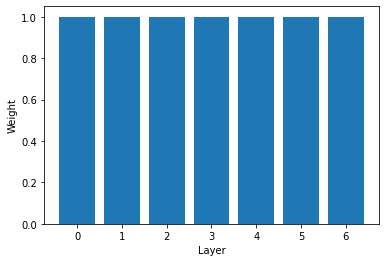

----------------




tensor([1, 1, 0, 1, 1, 1, 1, 0, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.50      0.54       223
    entailed       0.42      0.51      0.46       156

    accuracy                           0.50       379
   macro avg       0.50      0.50      0.50       379
weighted avg       0.52      0.50      0.51       379

MICRO F1: 0.503957783641161



tensor([0, 0, 0, 1, 1, 0, 1, 0, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.51      0.55       538
    entailed       0.45      0.52      0.48       411

    accuracy                           0.52       949
   macro avg       0.52      0.52      0.51       949
weighted avg       0.53      0.52      0.52       949

MICRO F1: 0.5163329820864068
[1] loss: 0.7170, val_loss: 0.7033, test_loss: 0.7006
[0.9923127293586731, 0.9934589862823486, 0.9968121647834778, 1.003072738647461, 1.0061166286468506, 1.0068769454956055, 1.0039676427841187]


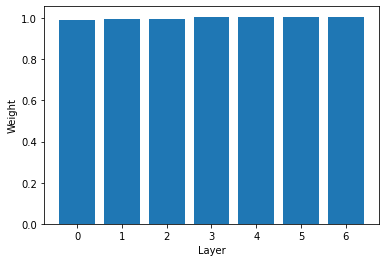

----------------




tensor([0, 0, 1, 0, 1, 1, 0, 1, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.47      0.48      0.47       187
    entailed       0.48      0.48      0.48       192

    accuracy                           0.48       379
   macro avg       0.48      0.48      0.48       379
weighted avg       0.48      0.48      0.48       379

MICRO F1: 0.47757255936675463



tensor([0, 1, 1, 0, 1, 0, 1, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.47      0.50      0.48       451
    entailed       0.52      0.50      0.51       498

    accuracy                           0.50       949
   macro avg       0.50      0.50      0.50       949
weighted avg       0.50      0.50      0.50       949

MICRO F1: 0.49841938883034775
[2] loss: 0.7026, val_loss: 0.7061, test_loss: 0.6999
[0.9876964688301086, 0.9865736365318298, 0.9853788614273071, 1.0010831356048584, 1.010835886001587, 1.0125362873077393, 1.0127428770065308]


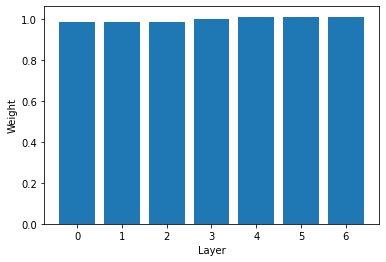

----------------




tensor([1, 1, 0, 0, 0, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.50      0.51      0.50       184
    entailed       0.53      0.51      0.52       195

    accuracy                           0.51       379
   macro avg       0.51      0.51      0.51       379
weighted avg       0.51      0.51      0.51       379

MICRO F1: 0.5118733509234829



tensor([0, 1, 0, 0, 0, 1, 1, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.49      0.50      0.50       466
    entailed       0.51      0.51      0.51       483

    accuracy                           0.50       949
   macro avg       0.50      0.50      0.50       949
weighted avg       0.50      0.50      0.50       949

MICRO F1: 0.5036880927291886
[3] loss: 0.7014, val_loss: 0.6994, test_loss: 0.6963
[0.9846463203430176, 0.9818835854530334, 0.9831030368804932, 1.001613736152649, 1.0140082836151123, 1.0153309106826782, 1.016767978668213]


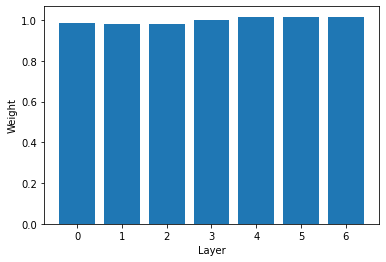

----------------




tensor([0, 1, 0, 1, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.47      0.49      0.48       180
    entailed       0.52      0.50      0.51       199

    accuracy                           0.50       379
   macro avg       0.50      0.50      0.50       379
weighted avg       0.50      0.50      0.50       379

MICRO F1: 0.49604221635883905



tensor([1, 0, 0, 0, 0, 0, 0, 1, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.51      0.51      0.51       475
    entailed       0.51      0.51      0.51       474

    accuracy                           0.51       949
   macro avg       0.51      0.51      0.51       949
weighted avg       0.51      0.51      0.51       949

MICRO F1: 0.5068493150684932
[4] loss: 0.7037, val_loss: 0.6999, test_loss: 0.7015
[0.9832109808921814, 0.9696027040481567, 0.9770336747169495, 0.9990222454071045, 1.0215984582901, 1.0172260999679565, 1.0254582166671753]


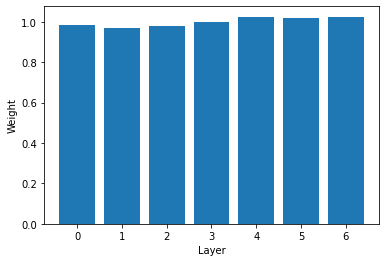

----------------




tensor([0, 0, 0, 0, 0, 0, 1, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.68      0.51      0.58       251
    entailed       0.35      0.52      0.42       128

    accuracy                           0.51       379
   macro avg       0.51      0.52      0.50       379
weighted avg       0.57      0.51      0.53       379

MICRO F1: 0.5145118733509235



tensor([0, 1, 0, 0, 0, 0, 0, 1, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.60      0.49      0.54       572
    entailed       0.39      0.49      0.44       377

    accuracy                           0.49       949
   macro avg       0.49      0.49      0.49       949
weighted avg       0.51      0.49      0.50       949

MICRO F1: 0.4931506849315068
[5] loss: 0.6953, val_loss: 0.6963, test_loss: 0.6974
[0.9724739193916321, 0.9451473951339722, 0.9630523324012756, 0.9972004294395447, 1.04593825340271, 1.0295957326889038, 1.033735752105713]


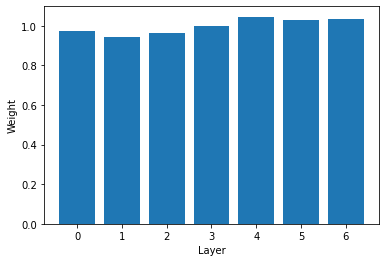

----------------




tensor([1, 1, 1, 0, 1, 0, 1, 0, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.62      0.52      0.57       224
    entailed       0.44      0.54      0.48       155

    accuracy                           0.53       379
   macro avg       0.53      0.53      0.52       379
weighted avg       0.54      0.53      0.53       379

MICRO F1: 0.5277044854881267



tensor([0, 0, 1, 0, 0, 1, 0, 0, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.60      0.53      0.56       528
    entailed       0.48      0.55      0.51       421

    accuracy                           0.54       949
   macro avg       0.54      0.54      0.54       949
weighted avg       0.55      0.54      0.54       949

MICRO F1: 0.5395152792413066
[6] loss: 0.6880, val_loss: 0.7019, test_loss: 0.6927
[0.9398325681686401, 0.8876689076423645, 0.9435669779777527, 1.0067811012268066, 1.1081000566482544, 1.0610569715499878, 1.0352762937545776]


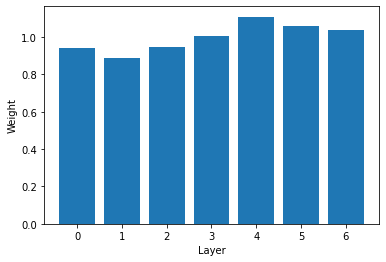

----------------




tensor([1, 1, 1, 1, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.54      0.56       205
    entailed       0.51      0.55      0.53       174

    accuracy                           0.55       379
   macro avg       0.55      0.55      0.55       379
weighted avg       0.55      0.55      0.55       379

MICRO F1: 0.5461741424802111



tensor([0, 1, 1, 0, 0, 1, 1, 0, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.55      0.53      0.54       490
    entailed       0.52      0.54      0.53       459

    accuracy                           0.54       949
   macro avg       0.54      0.54      0.54       949
weighted avg       0.54      0.54      0.54       949

MICRO F1: 0.5353003161222339
[7] loss: 0.6817, val_loss: 0.6863, test_loss: 0.6797
[0.8849932551383972, 0.8321362733840942, 0.9065951704978943, 0.9915385246276855, 1.1655418872833252, 1.1234824657440186, 1.0632805824279785]


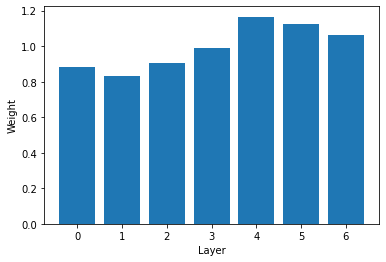

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.52      0.56      0.54       174
    entailed       0.60      0.56      0.58       205

    accuracy                           0.56       379
   macro avg       0.56      0.56      0.56       379
weighted avg       0.56      0.56      0.56       379

MICRO F1: 0.5593667546174143



tensor([0, 1, 1, 0, 0, 1, 1, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.59      0.58       463
    entailed       0.60      0.59      0.59       486

    accuracy                           0.59       949
   macro avg       0.59      0.59      0.59       949
weighted avg       0.59      0.59      0.59       949

MICRO F1: 0.589041095890411
[8] loss: 0.6626, val_loss: 0.6867, test_loss: 0.6706
[0.8413334488868713, 0.7902999520301819, 0.8702517151832581, 0.9651969075202942, 1.205012559890747, 1.18175208568573, 1.1004891395568848]


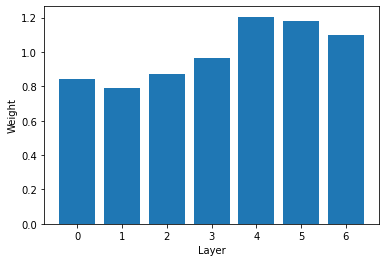

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.50      0.59      0.54       159
    entailed       0.66      0.57      0.61       220

    accuracy                           0.58       379
   macro avg       0.58      0.58      0.57       379
weighted avg       0.59      0.58      0.58       379

MICRO F1: 0.5778364116094987



tensor([0, 1, 1, 0, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.60      0.57       424
    entailed       0.64      0.58      0.61       525

    accuracy                           0.59       949
   macro avg       0.59      0.59      0.59       949
weighted avg       0.60      0.59      0.59       949

MICRO F1: 0.5922023182297155
[9] loss: 0.6472, val_loss: 0.6837, test_loss: 0.6744
[0.8136050701141357, 0.7558932900428772, 0.8357780575752258, 0.9369254112243652, 1.2331830263137817, 1.2324652671813965, 1.1335941553115845]


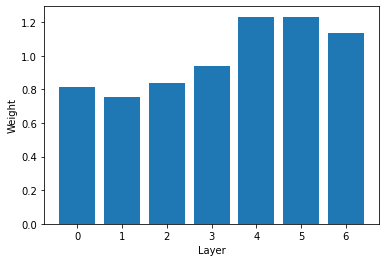

----------------




tensor([1, 1, 1, 1, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.44      0.56      0.49       147
    entailed       0.66      0.54      0.60       232

    accuracy                           0.55       379
   macro avg       0.55      0.55      0.55       379
weighted avg       0.58      0.55      0.56       379

MICRO F1: 0.5514511873350924



tensor([0, 1, 1, 0, 0, 1, 0, 1, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.53      0.59      0.56       425
    entailed       0.63      0.57      0.60       524

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.59      0.58      0.58       949

MICRO F1: 0.5806111696522656
[10] loss: 0.6488, val_loss: 0.6859, test_loss: 0.6781
[0.784475564956665, 0.7263475656509399, 0.8026572465896606, 0.9091454148292542, 1.2593787908554077, 1.2830824851989746, 1.1637742519378662]


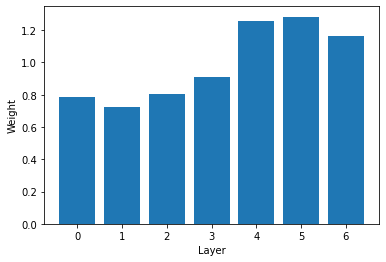

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.55      0.56      0.56       185
    entailed       0.57      0.56      0.57       194

    accuracy                           0.56       379
   macro avg       0.56      0.56      0.56       379
weighted avg       0.56      0.56      0.56       379

MICRO F1: 0.5620052770448549



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.61      0.58      0.60       498
    entailed       0.56      0.59      0.58       451

    accuracy                           0.59       949
   macro avg       0.59      0.59      0.59       949
weighted avg       0.59      0.59      0.59       949

MICRO F1: 0.5858798735511064
[11] loss: 0.6381, val_loss: 0.7027, test_loss: 0.6834
[0.7704209089279175, 0.7053185701370239, 0.7733650803565979, 0.8822821378707886, 1.2711727619171143, 1.3223826885223389, 1.1996961832046509]


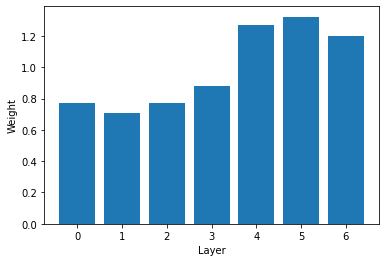

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 0, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.50      0.60      0.55       158
    entailed       0.67      0.57      0.62       221

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.58       379
weighted avg       0.60      0.59      0.59       379

MICRO F1: 0.5857519788918206



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.59      0.59       466
    entailed       0.60      0.59      0.59       483

    accuracy                           0.59       949
   macro avg       0.59      0.59      0.59       949
weighted avg       0.59      0.59      0.59       949

MICRO F1: 0.5900948366701791
[12] loss: 0.6221, val_loss: 0.6865, test_loss: 0.6753
[0.7515983581542969, 0.6824550032615662, 0.7469679117202759, 0.8573805689811707, 1.2836061716079712, 1.3648220300674438, 1.2289551496505737]


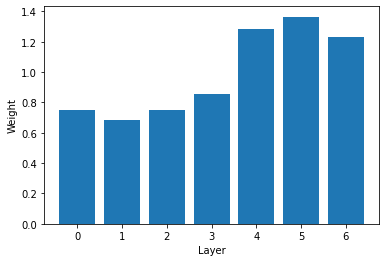

----------------




tensor([1, 0, 1, 0, 1, 0, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.49      0.55      0.52       170
    entailed       0.59      0.54      0.57       209

    accuracy                           0.54       379
   macro avg       0.54      0.54      0.54       379
weighted avg       0.55      0.54      0.54       379

MICRO F1: 0.5435356200527705



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.57      0.58       487
    entailed       0.56      0.58      0.57       462

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.58      0.58      0.58       949

MICRO F1: 0.5763962065331928
[13] loss: 0.6093, val_loss: 0.7179, test_loss: 0.6911
[0.7289132475852966, 0.6562069654464722, 0.7204464673995972, 0.8358646631240845, 1.299432635307312, 1.4070749282836914, 1.2564746141433716]


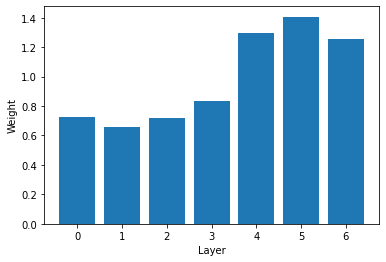

----------------




tensor([1, 1, 1, 0, 1, 0, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.56      0.55       184
    entailed       0.57      0.56      0.57       195

    accuracy                           0.56       379
   macro avg       0.56      0.56      0.56       379
weighted avg       0.56      0.56      0.56       379

MICRO F1: 0.5593667546174143



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.61      0.57      0.59       502
    entailed       0.55      0.59      0.57       447

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.58      0.58      0.58       949

MICRO F1: 0.5795574288724974
[14] loss: 0.6046, val_loss: 0.7537, test_loss: 0.7104
[0.7084416151046753, 0.6317164301872253, 0.6962549090385437, 0.8156710267066956, 1.3141440153121948, 1.4475452899932861, 1.2734429836273193]


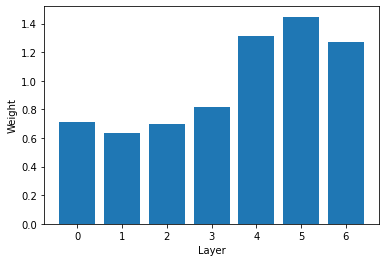

----------------




tensor([1, 0, 1, 1, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.62      0.58      0.60       202
    entailed       0.55      0.59      0.57       177

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.59       379
weighted avg       0.59      0.59      0.59       379

MICRO F1: 0.5857519788918206



tensor([0, 1, 1, 0, 1, 1, 1, 0, 1])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.63      0.57      0.60       524
    entailed       0.53      0.59      0.55       425

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.58      0.58      0.58       949

MICRO F1: 0.5774499473129611
[15] loss: 0.6229, val_loss: 0.7066, test_loss: 0.6837
[0.6899574398994446, 0.6121318936347961, 0.6785303950309753, 0.8008267879486084, 1.3241392374038696, 1.4811248779296875, 1.2909348011016846]


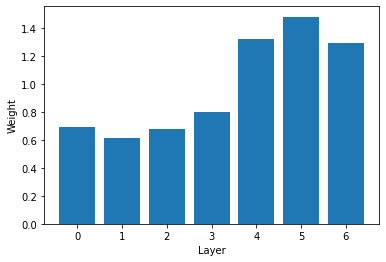

----------------




tensor([1, 0, 1, 0, 1, 0, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.62      0.57      0.60       207
    entailed       0.53      0.59      0.56       172

    accuracy                           0.58       379
   macro avg       0.58      0.58      0.58       379
weighted avg       0.58      0.58      0.58       379

MICRO F1: 0.5778364116094987



tensor([0, 1, 0, 0, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.66      0.57      0.61       553
    entailed       0.50      0.60      0.54       396

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.59      0.58      0.58       949

MICRO F1: 0.5785036880927292
[16] loss: 0.6244, val_loss: 0.7058, test_loss: 0.6728
[0.6772605180740356, 0.595431387424469, 0.6621355414390564, 0.77923184633255, 1.3314749002456665, 1.5134259462356567, 1.3057913780212402]


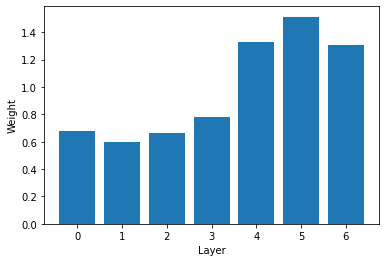

----------------




tensor([0, 1, 1, 0, 1, 0, 1, 0, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.64      0.58      0.61       208
    entailed       0.54      0.60      0.57       171

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.59       379
weighted avg       0.60      0.59      0.59       379

MICRO F1: 0.5910290237467019



tensor([0, 1, 0, 1, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.66      0.59      0.62       531
    entailed       0.54      0.61      0.57       418

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.60      0.60      0.60       949

MICRO F1: 0.5974710221285564
[17] loss: 0.5894, val_loss: 0.7110, test_loss: 0.6943
[0.6616241931915283, 0.5786386728286743, 0.6422241926193237, 0.7566288113594055, 1.3405203819274902, 1.547438144683838, 1.3211089372634888]


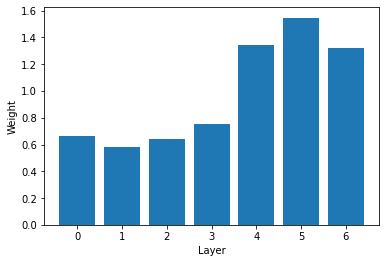

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.56      0.58      0.57       184
    entailed       0.59      0.57      0.58       195

    accuracy                           0.58       379
   macro avg       0.58      0.58      0.58       379
weighted avg       0.58      0.58      0.58       379

MICRO F1: 0.575197889182058



tensor([0, 1, 1, 1, 0, 1, 1, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.60      0.59       463
    entailed       0.61      0.59      0.60       486

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.60      0.60      0.60       949

MICRO F1: 0.59536354056902
[18] loss: 0.5730, val_loss: 0.7391, test_loss: 0.6977
[0.6500940322875977, 0.5614234209060669, 0.624069094657898, 0.7374425530433655, 1.3491387367248535, 1.5776118040084839, 1.3298406600952148]


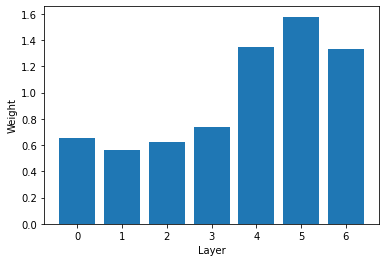

----------------




tensor([1, 1, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.51      0.61      0.56       158
    entailed       0.68      0.58      0.63       221

    accuracy                           0.60       379
   macro avg       0.60      0.60      0.59       379
weighted avg       0.61      0.60      0.60       379

MICRO F1: 0.5963060686015831



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.55      0.59      0.57       445
    entailed       0.62      0.58      0.60       504

    accuracy                           0.58       949
   macro avg       0.58      0.59      0.58       949
weighted avg       0.59      0.58      0.59       949

MICRO F1: 0.5848261327713382
[19] loss: 0.5619, val_loss: 0.7193, test_loss: 0.7267
[0.6381681561470032, 0.5446807146072388, 0.6060324907302856, 0.7174641489982605, 1.3559722900390625, 1.6096290349960327, 1.3387502431869507]


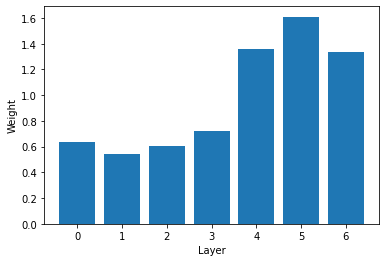

----------------




tensor([0, 0, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.61      0.59      0.60       198
    entailed       0.57      0.60      0.58       181

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.59       379
weighted avg       0.59      0.59      0.59       379

MICRO F1: 0.5910290237467019



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.61      0.58      0.59       500
    entailed       0.56      0.59      0.57       449

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.59      0.58      0.58       949

MICRO F1: 0.58377239199157
[20] loss: 0.5520, val_loss: 0.7346, test_loss: 0.7124
[0.628176212310791, 0.5260618329048157, 0.5858470797538757, 0.6928576231002808, 1.3622117042541504, 1.6427453756332397, 1.349893569946289]


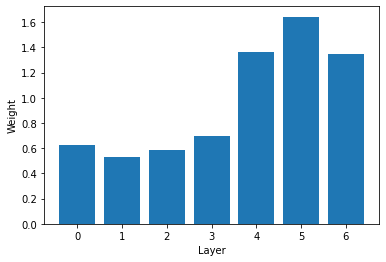

----------------




tensor([1, 0, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.57      0.58       197
    entailed       0.55      0.58      0.56       182

    accuracy                           0.57       379
   macro avg       0.57      0.57      0.57       379
weighted avg       0.57      0.57      0.57       379

MICRO F1: 0.5725593667546174



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.67      0.58      0.62       539
    entailed       0.53      0.61      0.57       410

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.61      0.60      0.60       949

MICRO F1: 0.5974710221285564
[21] loss: 0.5400, val_loss: 0.7432, test_loss: 0.7277
[0.6176066398620605, 0.507026731967926, 0.5666525959968567, 0.6682952046394348, 1.3670471906661987, 1.678525686264038, 1.3580949306488037]


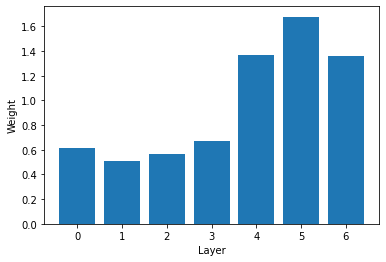

----------------




tensor([0, 1, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.57      0.58       192
    entailed       0.57      0.58      0.57       187

    accuracy                           0.58       379
   macro avg       0.58      0.58      0.58       379
weighted avg       0.58      0.58      0.58       379

MICRO F1: 0.575197889182058



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.63      0.59      0.61       506
    entailed       0.57      0.61      0.59       443

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.60      0.60      0.60       949

MICRO F1: 0.5985247629083246
[22] loss: 0.5366, val_loss: 0.7449, test_loss: 0.7196
[0.6050077676773071, 0.4852120280265808, 0.5424716472625732, 0.6415738463401794, 1.377773642539978, 1.7124123573303223, 1.3640284538269043]


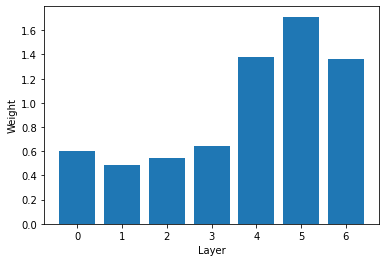

----------------




tensor([1, 1, 0, 0, 1, 0, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.59      0.57       175
    entailed       0.62      0.58      0.60       204

    accuracy                           0.58       379
   macro avg       0.58      0.58      0.58       379
weighted avg       0.59      0.58      0.58       379

MICRO F1: 0.58311345646438



tensor([0, 1, 0, 1, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.60      0.60       465
    entailed       0.61      0.60      0.61       484

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.60      0.60      0.60       949

MICRO F1: 0.6037934668071654
[23] loss: 0.5335, val_loss: 0.7444, test_loss: 0.7090
[0.5918630361557007, 0.46535250544548035, 0.5182487368583679, 0.6157774925231934, 1.3841829299926758, 1.749395728111267, 1.3724254369735718]


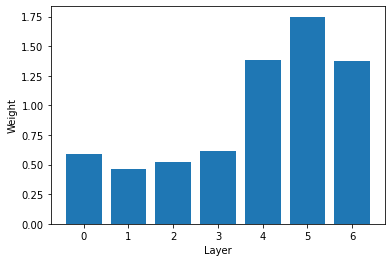

----------------




tensor([1, 1, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.55      0.62      0.58       169
    entailed       0.66      0.60      0.62       210

    accuracy                           0.60       379
   macro avg       0.60      0.61      0.60       379
weighted avg       0.61      0.60      0.61       379

MICRO F1: 0.604221635883905



tensor([0, 1, 1, 0, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.58      0.58      0.58       475
    entailed       0.58      0.58      0.58       474

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.58      0.58      0.58       949

MICRO F1: 0.5827186512118019
[24] loss: 0.5446, val_loss: 0.7265, test_loss: 0.7261
[0.5756665468215942, 0.4438121020793915, 0.49430984258651733, 0.5932274460792542, 1.3956598043441772, 1.779884696006775, 1.380873441696167]


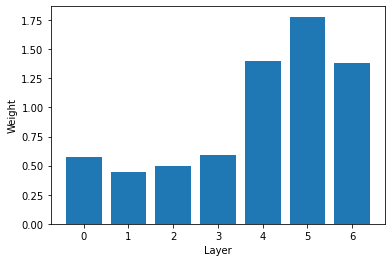

----------------




tensor([0, 0, 0, 0, 1, 0, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.58      0.56       177
    entailed       0.61      0.57      0.59       202

    accuracy                           0.57       379
   macro avg       0.57      0.57      0.57       379
weighted avg       0.57      0.57      0.57       379

MICRO F1: 0.5725593667546174



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.59      0.60      0.60       467
    entailed       0.61      0.60      0.60       482

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.60      0.60      0.60       949

MICRO F1: 0.5995785036880927
[25] loss: 0.5545, val_loss: 0.7221, test_loss: 0.6989
[0.5636587738990784, 0.4247410297393799, 0.47350767254829407, 0.5740672945976257, 1.404770851135254, 1.807023286819458, 1.3858429193496704]


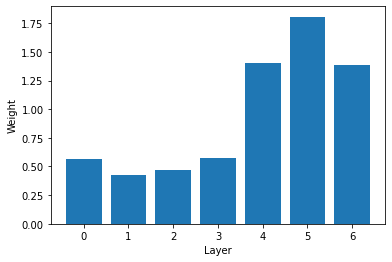

----------------




tensor([1, 1, 1, 0, 1, 0, 0, 1, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.49      0.59      0.53       157
    entailed       0.66      0.56      0.61       222

    accuracy                           0.57       379
   macro avg       0.57      0.57      0.57       379
weighted avg       0.59      0.57      0.58       379

MICRO F1: 0.5725593667546174



tensor([0, 1, 1, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.61      0.57       414
    entailed       0.66      0.59      0.63       535

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.61      0.60      0.60       949

MICRO F1: 0.6006322444678609
[26] loss: 0.5374, val_loss: 0.7291, test_loss: 0.7313
[0.5528545379638672, 0.4105982184410095, 0.4556349217891693, 0.554473340511322, 1.4120060205459595, 1.831693172454834, 1.388956069946289]


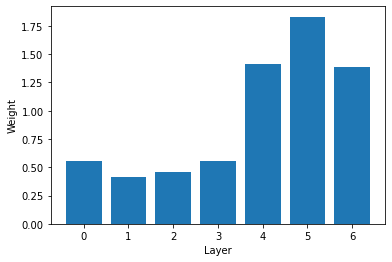

----------------




tensor([1, 0, 0, 0, 1, 0, 1, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.44      0.60      0.51       138
    entailed       0.71      0.56      0.63       241

    accuracy                           0.58       379
   macro avg       0.57      0.58      0.57       379
weighted avg       0.61      0.58      0.58       379

MICRO F1: 0.575197889182058



tensor([0, 1, 0, 0, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.54      0.62      0.57       414
    entailed       0.67      0.59      0.63       535

    accuracy                           0.60       949
   macro avg       0.60      0.60      0.60       949
weighted avg       0.61      0.60      0.60       949

MICRO F1: 0.6027397260273972
[27] loss: 0.5338, val_loss: 0.7209, test_loss: 0.7342
[0.5423650145530701, 0.3971315920352936, 0.4419514834880829, 0.5392207503318787, 1.4156121015548706, 1.8540340662002563, 1.3971381187438965]


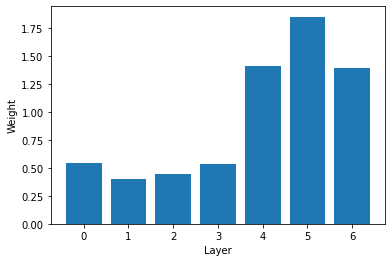

----------------




tensor([1, 0, 0, 0, 1, 1, 0, 1, 1])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.46      0.66      0.54       132
    entailed       0.76      0.59      0.66       247

    accuracy                           0.61       379
   macro avg       0.61      0.62      0.60       379
weighted avg       0.66      0.61      0.62       379

MICRO F1: 0.6121372031662269



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.49      0.59      0.54       392
    entailed       0.67      0.57      0.61       557

    accuracy                           0.58       949
   macro avg       0.58      0.58      0.58       949
weighted avg       0.59      0.58      0.58       949

MICRO F1: 0.5795574288724974
[28] loss: 0.5093, val_loss: 0.7149, test_loss: 0.7794
[0.5354623198509216, 0.3859889507293701, 0.4285300374031067, 0.5245586633682251, 1.4171897172927856, 1.8759493827819824, 1.4015998840332031]


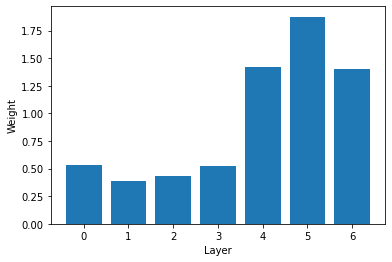

----------------




tensor([1, 0, 0, 0, 1, 1, 0, 1, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.42      0.55      0.48       145
    entailed       0.66      0.53      0.59       234

    accuracy                           0.54       379
   macro avg       0.54      0.54      0.53       379
weighted avg       0.57      0.54      0.55       379

MICRO F1: 0.5408970976253298



tensor([0, 1, 0, 1, 0, 1, 0, 1, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.49      0.55      0.51       421
    entailed       0.60      0.54      0.57       528

    accuracy                           0.54       949
   macro avg       0.54      0.54      0.54       949
weighted avg       0.55      0.54      0.54       949

MICRO F1: 0.5426765015806112
[29] loss: 0.5021, val_loss: 0.7760, test_loss: 0.8039
[0.5265727043151855, 0.37287071347236633, 0.4153622090816498, 0.5099591016769409, 1.4187644720077515, 1.9004428386688232, 1.4055286645889282]


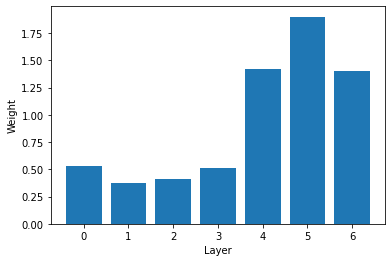

----------------




tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])
[1 0 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.51      0.55      0.53       173
    entailed       0.59      0.55      0.57       206

    accuracy                           0.55       379
   macro avg       0.55      0.55      0.55       379
weighted avg       0.56      0.55      0.55       379

MICRO F1: 0.5514511873350924



tensor([0, 0, 0, 1, 0, 1, 0, 0, 0])
[0 1 1 0 1 0 0 1 0]
              precision    recall  f1-score   support

not-entailed       0.52      0.52      0.52       466
    entailed       0.53      0.53      0.53       483

    accuracy                           0.52       949
   macro avg       0.52      0.52      0.52       949
weighted avg       0.52      0.52      0.52       949

MICRO F1: 0.5247629083245522
[30] loss: 0.5095, val_loss: 0.7660, test_loss: 0.7748


In [112]:
my_edge_probe_trainer.train(batch_size = 16, epochs=30)

In [ ]:
torch.save(my_edge_probe_trainer.edge_probe_model.state_dict(), "EPM_xlnet-large-cased(After 4 Epoch)")

In [ ]:
# TODO: Cache BERT predictions as much as RAM allows

Loss History
{'train': [0.7339804656803608, 0.7169645572347301, 0.7025670829628196, 0.7013989388942719, 0.7036952977733952, 0.6952892398195607, 0.6879672072827816, 0.6816847388233457, 0.6625581083020994, 0.6471880126212325, 0.6488445161708764, 0.638057089011584, 0.6220521788511958, 0.6093363889626094, 0.6045644586639745, 0.6228605726999896, 0.624438169545361, 0.5894196118627276, 0.5729864574968815, 0.5619110230888639, 0.551995969244412, 0.5399562438417759, 0.53655947518668, 0.5335024704358408, 0.5446317444688508, 0.5544546903776271, 0.5374002873099276, 0.5337785378630672, 0.50932088760393, 0.5020890833277788, 0.5094520911308271], 'dev': [0.7304809937874476, 0.7033360625306765, 0.706075499455134, 0.6993758703271548, 0.6999060362577438, 0.6963001439968745, 0.7018802662690481, 0.6863104030489922, 0.6866926401853561, 0.6836862564086914, 0.6858643367886543, 0.7027242258191109, 0.686483604212602, 0.7179011752208074, 0.7537226378917694, 0.7066096564133962, 0.705767256518205, 0.710988648235797

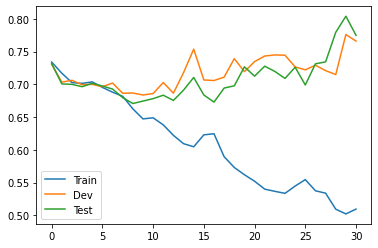

.
Micro f1 History
{'dev': [0.5197889182058048, 0.503957783641161, 0.47757255936675463, 0.5118733509234829, 0.49604221635883905, 0.5145118733509235, 0.5277044854881267, 0.5461741424802111, 0.5593667546174143, 0.5778364116094987, 0.5514511873350924, 0.5620052770448549, 0.5857519788918206, 0.5435356200527705, 0.5593667546174143, 0.5857519788918206, 0.5778364116094987, 0.5910290237467019, 0.575197889182058, 0.5963060686015831, 0.5910290237467019, 0.5725593667546174, 0.575197889182058, 0.58311345646438, 0.604221635883905, 0.5725593667546174, 0.5725593667546174, 0.575197889182058, 0.6121372031662269, 0.5408970976253298, 0.5514511873350924], 'test': [0.5131717597471022, 0.5163329820864068, 0.49841938883034775, 0.5036880927291886, 0.5068493150684932, 0.4931506849315068, 0.5395152792413066, 0.5353003161222339, 0.589041095890411, 0.5922023182297155, 0.5806111696522656, 0.5858798735511064, 0.5900948366701791, 0.5763962065331928, 0.5795574288724974, 0.5774499473129611, 0.5785036880927292, 0.59747

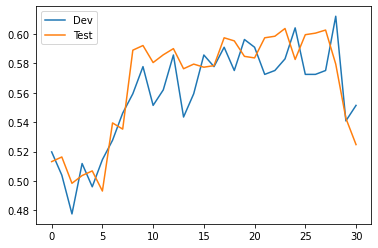

.


In [119]:
print("Loss History")
print(my_edge_probe_trainer.history["loss"])
loss_history = my_edge_probe_trainer.history["loss"]
x = range(len(loss_history["train"]))
plt.plot(x, loss_history["train"])
plt.plot(x, loss_history["dev"])
plt.plot(x, loss_history["test"])
plt.legend(['Train', 'Dev', 'Test'], loc='lower left')
plt.show()
print(".")

print("Micro f1 History")
f1_history = my_edge_probe_trainer.history["metrics"]["micro_f1"]
print(f1_history)
x = range(len(f1_history["dev"]))
plt.plot(x, f1_history["dev"])
plt.plot(x, f1_history["test"])
plt.legend(['Dev', 'Test'], loc='upper left')
plt.show()
print(".")